# Домашнє завдання: "Стрес-тест для Перцептрона"

**Мета:** Дослідити поведінку перцептрона у складних умовах (коли класи перетинаються) та навчитися оцінювати його роботу не тільки за точністю, але й за F1-score та матрицею плутанини.

**Базовий файл:** `perceptron.py` (або ваш Notebook з лекції).

---

### 🟢 Рівень 1: "Хаос у саду" (Експерименти з даними)

У нашому прикладі на лекції яблука та груші ідеально розділені. Але в реальності бувають дрібні яблука і великі груші.

**Завдання:**

1. Знайдіть у коді блок генерації даних (`# 1. Генеруємо синтетичні дані`).
2. Збільшіть стандартне відхилення (`scale` у `np.random.normal`) для обох класів з `10` до `30` (для ваги) та з `0.1` до `0.3` (для кольору).
    * *Підказка:* Це зробить "хмари" точок ширшими, і вони почнуть налазить одна на одну.
3. Запустіть навчання.
4. **Питання:** Чи змогла модель досягти 0 помилок? Як змінився графік "Розділення класів"? Зробіть скріншот. - Ні модель не змогла досягти 0 помилок, графік "Розділення класів" змінився (Точки почали накладуватися одна на одну).

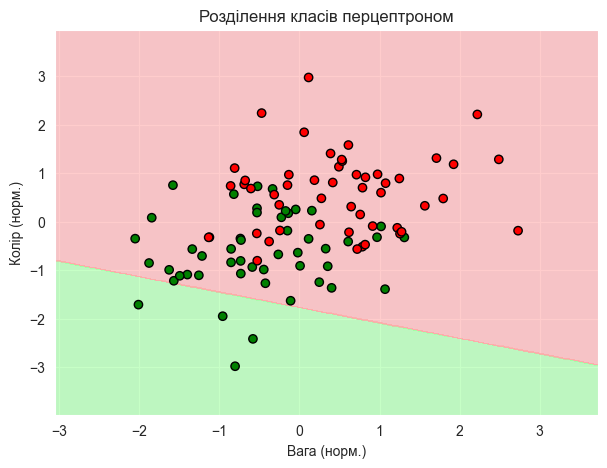

Зразок 1: [0.1 0.1] -> Яблуко 🍎
Зразок 2: [1.  0.8] -> Яблуко 🍎
Зразок 3: [0.3 0.6] -> Яблуко 🍎


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ---------------------------
# 1. Генеруємо синтетичні дані
# ---------------------------
np.random.seed(42)

# Клас 0: груші (легкі, світлі)
pear_weight = np.random.normal(150, 30, 50)
pear_color = np.random.normal(0.3, 0.3, 50)

# Клас 1: яблука (важчі, темніші)
apple_weight = np.random.normal(180, 30, 50)
apple_color = np.random.normal(0.7, 0.3, 50)

# Об'єднуємо дані
X = np.vstack((
    np.column_stack((pear_weight, pear_color)),
    np.column_stack((apple_weight, apple_color))
))
y = np.array([0] * 50 + [1] * 50)

# Нормалізація ознак
X = (X - X.mean(axis=0)) / X.std(axis=0)

# ---------------------------
# 2. Реалізація перцептрона з нуля
# ---------------------------
class Perceptron:
    def __init__(self, n_inputs, learning_rate=0.1, epochs=50):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = np.zeros(n_inputs)
        self.bias = 0.0

    def step(self, x):
        """Порогова функція активації"""
        return np.where(x >= 0, 1, 0)

    def predict(self, X):
        """Передбачення класу"""
        linear_output = np.dot(X, self.weights) + self.bias
        return self.step(linear_output)

    def fit(self, X, y):
        """Навчання моделі"""
        for epoch in range(self.epochs):
            for xi, target in zip(X, y):
                y_pred = self.predict(xi)
                update = self.lr * (target - y_pred)
                self.weights += update * xi
                self.bias += update

# ---------------------------
# 3. Навчання моделі
# ---------------------------
model = Perceptron(n_inputs=2, learning_rate=0.1, epochs=10)
model.fit(X, y)

# ---------------------------
# 4. Побудова розділяючої лінії
# ---------------------------
def plot_decision_boundary(model, X, y):
    cmap_light = ListedColormap(['#A0FFA0', '#FFAAAA'])
    cmap_bold = ['green', 'red']

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(cmap_bold), edgecolor='k')
    plt.title("Розділення класів перцептроном")
    plt.xlabel("Вага (норм.)")
    plt.ylabel("Колір (норм.)")
    plt.show()


plot_decision_boundary(model, X, y)

# ---------------------------
# 5. Перевірка на нових даних
# ---------------------------
new_samples = np.array([
    [0.1, 0.1],  # легка і світла -> груша
    [1.0, 0.8],  # важка і темна -> яблуко
    [0.3, 0.6],  # проміжне
])

predictions = model.predict(new_samples)
for i, p in enumerate(predictions):
    label = "Яблуко 🍎" if p == 1 else "Груша 🍐"
    print(f"Зразок {i + 1}: {new_samples[i]} -> {label}")

### 🟡 Рівень 2: "Детектив метрик" (Аналіз помилок)

Коли дані перемішані, `Accuracy` (загальна точність) перестає бути інформативною.

**Завдання:**

1. Використовуючи "складні дані" з Рівня 1, навчіть модель.
2. Виведіть **Матрицю плутанини (Confusion Matrix)** та звіт `classification_report`.
3. Дайте відповідь на питання:
    * Чого більше: "Хибних тривог" (Грушу назвали Яблуком — FP) чи "Пропусків" (Яблуко назвали Грушею — FN)? - більше FP Грушу назвали Яблуком
    * Чому, на вашу думку, перцептрон помиляється саме так? (Подивіться на лінію розділення). - коли точкові хмари змішалися, класи перестали бути лінійно роздільними, перцептрон намагаєтьмя мінімізувати загальну кількість помилок за допомогою лише однієї прямої, червоні точки вони знаходяться ближче до центру, і тому алгоритм відає їм більше простору, щоб помилитися на кількох зелених точках, але правильно класифікувати більшість червоних.

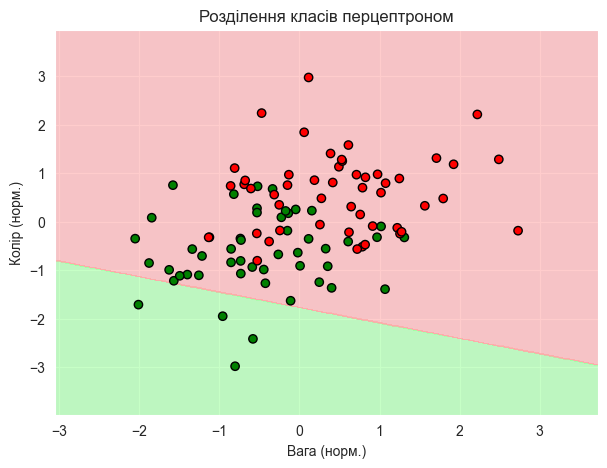

Зразок 1: [0.1 0.1] -> Яблуко 🍎
Зразок 2: [1.  0.8] -> Яблуко 🍎
Зразок 3: [0.3 0.6] -> Яблуко 🍎


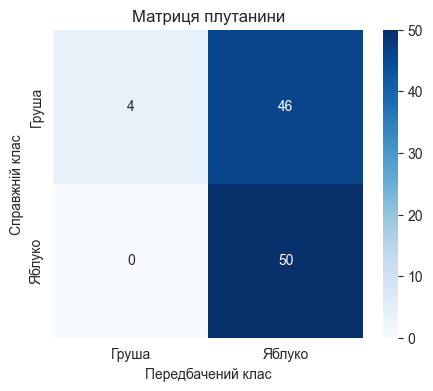

Звіт класифікації:
              precision    recall  f1-score   support

       Груша       1.00      0.08      0.15        50
      Яблуко       0.52      1.00      0.68        50

    accuracy                           0.54       100
   macro avg       0.76      0.54      0.42       100
weighted avg       0.76      0.54      0.42       100



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ---------------------------
# 1. Генеруємо синтетичні дані
# ---------------------------
np.random.seed(42)

# Клас 0: груші (легкі, світлі)
pear_weight = np.random.normal(150, 30, 50)
pear_color = np.random.normal(0.3, 0.3, 50)

# Клас 1: яблука (важчі, темніші)
apple_weight = np.random.normal(180, 30, 50)
apple_color = np.random.normal(0.7, 0.3, 50)

# Об'єднуємо дані
X = np.vstack((
    np.column_stack((pear_weight, pear_color)),
    np.column_stack((apple_weight, apple_color))
))
y = np.array([0] * 50 + [1] * 50)

# Нормалізація ознак
X = (X - X.mean(axis=0)) / X.std(axis=0)

# ---------------------------
# 2. Візуалізація вихідних даних
# ---------------------------
def evaluate_model(model, X, y):
    y_pred = model.predict(X)

    # Матриця плутанини
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Груша', 'Яблуко'],
                yticklabels=['Груша', 'Яблуко'])
    plt.title("Матриця плутанини")
    plt.xlabel("Передбачений клас")
    plt.ylabel("Справжній клас")
    plt.show()

    # Звіт класифікації
    print("Звіт класифікації:")
    print(classification_report(y, y_pred, target_names=['Груша', 'Яблуко']))


# ---------------------------
# 3. Реалізація перцептрона з нуля
# ---------------------------
class Perceptron:
    def __init__(self, n_inputs, learning_rate=0.1, epochs=50):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = np.zeros(n_inputs)
        self.bias = 0.0

    def step(self, x):
        """Порогова функція активації"""
        return np.where(x >= 0, 1, 0)

    def predict(self, X):
        """Передбачення класу"""
        linear_output = np.dot(X, self.weights) + self.bias
        return self.step(linear_output)

    def fit(self, X, y):
        """Навчання моделі"""
        for epoch in range(self.epochs):
            for xi, target in zip(X, y):
                y_pred = self.predict(xi)
                update = self.lr * (target - y_pred)
                self.weights += update * xi
                self.bias += update


# ---------------------------
# 4. Навчання моделі
# ---------------------------
model = Perceptron(n_inputs=2, learning_rate=0.1, epochs=10)
model.fit(X, y)

# ---------------------------
# 5. Побудова розділяючої лінії
# ---------------------------
def plot_decision_boundary(model, X, y):
    cmap_light = ListedColormap(['#A0FFA0', '#FFAAAA'])
    cmap_bold = ['green', 'red']

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(cmap_bold), edgecolor='k')
    plt.title("Розділення класів перцептроном")
    plt.xlabel("Вага (норм.)")
    plt.ylabel("Колір (норм.)")
    plt.show()


plot_decision_boundary(model, X, y)

# ---------------------------
# 6. Перевірка на нових даних
# ---------------------------
new_samples = np.array([
    [0.1, 0.1],  # легка і світла -> груша
    [1.0, 0.8],  # важка і темна -> яблуко
    [0.3, 0.6],  # проміжне
])

predictions = model.predict(new_samples)
for i, p in enumerate(predictions):
    label = "Яблуко 🍎" if p == 1 else "Груша 🍐"
    print(f"Зразок {i + 1}: {new_samples[i]} -> {label}")

# Оцінка моделі на тестових даних
evaluate_model(model, X, y)

### 🔴 Рівень 3: "Налаштування мозку" (Гіперпараметри)

Перцептрон дуже чутливий до швидкості навчання (`learning_rate`).

**Завдання:**

1. Поверніть дані до "нормального" стану (як було на лекції).
2. Змініть `learning_rate` на дуже велике число (наприклад, `1.0` або `10.0`). Що відбувається з графіком помилок? Він стабільно падає чи "стрибає"? - При lr=10.0 та epochs=5, Графік помилок стабільно падає.
3. Змініть `learning_rate` на дуже мале число (наприклад, `0.0001`) і збільшіть кількість епох до `100`. - При lr=0.0001 epochs=100, Графік помилок також стабільно падає.
4. **Висновок:** Який `learning_rate` виявився найкращим для цієї задачі і чому? - Найкращий learning_rate це 10.0 тому, що він менше затрачає ресурси ніж 0.0001.

Епоха 1/100 — помилки: 2
Епоха 2/100 — помилки: 0
Епоха 3/100 — помилки: 0
Епоха 4/100 — помилки: 0
Епоха 5/100 — помилки: 0
Епоха 6/100 — помилки: 0
Епоха 7/100 — помилки: 0
Епоха 8/100 — помилки: 0
Епоха 9/100 — помилки: 0
Епоха 10/100 — помилки: 0
Епоха 11/100 — помилки: 0
Епоха 12/100 — помилки: 0
Епоха 13/100 — помилки: 0
Епоха 14/100 — помилки: 0
Епоха 15/100 — помилки: 0
Епоха 16/100 — помилки: 0
Епоха 17/100 — помилки: 0
Епоха 18/100 — помилки: 0
Епоха 19/100 — помилки: 0
Епоха 20/100 — помилки: 0
Епоха 21/100 — помилки: 0
Епоха 22/100 — помилки: 0
Епоха 23/100 — помилки: 0
Епоха 24/100 — помилки: 0
Епоха 25/100 — помилки: 0
Епоха 26/100 — помилки: 0
Епоха 27/100 — помилки: 0
Епоха 28/100 — помилки: 0
Епоха 29/100 — помилки: 0
Епоха 30/100 — помилки: 0
Епоха 31/100 — помилки: 0
Епоха 32/100 — помилки: 0
Епоха 33/100 — помилки: 0
Епоха 34/100 — помилки: 0
Епоха 35/100 — помилки: 0
Епоха 36/100 — помилки: 0
Епоха 37/100 — помилки: 0
Епоха 38/100 — помилки: 0
Епоха 39/100 — помилк

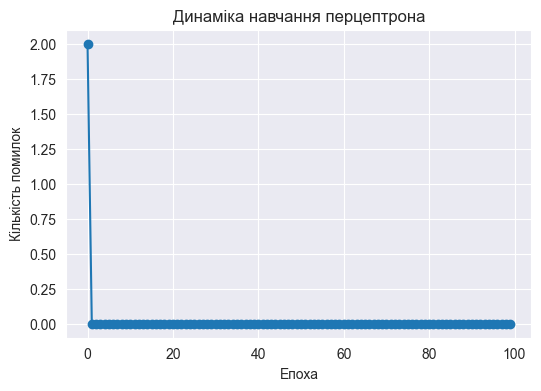

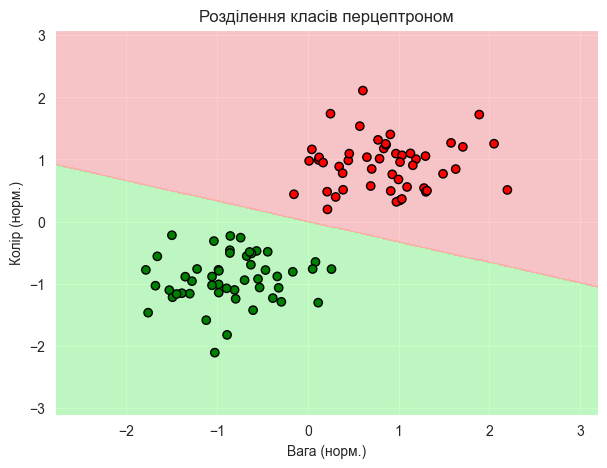

Зразок 1: [0.1 0.1] -> Яблуко 🍎
Зразок 2: [1.  0.8] -> Яблуко 🍎
Зразок 3: [0.3 0.6] -> Яблуко 🍎


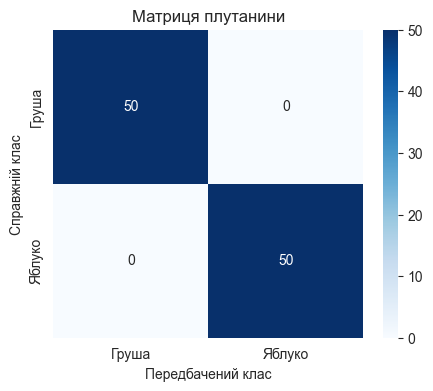

Звіт класифікації:
              precision    recall  f1-score   support

       Груша       1.00      1.00      1.00        50
      Яблуко       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ---------------------------
# 1. Генеруємо синтетичні дані
# ---------------------------
np.random.seed(42)

# Клас 0: груші (легкі, світлі)
pear_weight = np.random.normal(150, 10, 50)
pear_color = np.random.normal(0.3, 0.1, 50)

# Клас 1: яблука (важчі, темніші)
apple_weight = np.random.normal(180, 10, 50)
apple_color = np.random.normal(0.7, 0.1, 50)

# Об'єднуємо дані
X = np.vstack((
    np.column_stack((pear_weight, pear_color)),
    np.column_stack((apple_weight, apple_color))
))
y = np.array([0] * 50 + [1] * 50)

# Нормалізація ознак
X = (X - X.mean(axis=0)) / X.std(axis=0)


# ---------------------------
# 2. Візуалізація вихідних даних
# ---------------------------
def evaluate_model(model, X, y):
    y_pred = model.predict(X)

    # Матриця плутанини
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Груша', 'Яблуко'],
                yticklabels=['Груша', 'Яблуко'])
    plt.title("Матриця плутанини")
    plt.xlabel("Передбачений клас")
    plt.ylabel("Справжній клас")
    plt.show()

    # Звіт класифікації
    print("Звіт класифікації:")
    print(classification_report(y, y_pred, target_names=['Груша', 'Яблуко']))


# ---------------------------
# 3. Реалізація перцептрона з нуля
# ---------------------------
class Perceptron:
    def __init__(self, n_inputs, learning_rate=0.1, epochs=50):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = np.zeros(n_inputs)
        self.bias = 0.0

    def step(self, x):
        """Порогова функція активації"""
        return np.where(x >= 0, 1, 0)

    def predict(self, X):
        """Передбачення класу"""
        linear_output = np.dot(X, self.weights) + self.bias
        return self.step(linear_output)

    def fit(self, X, y):
        """Навчання моделі"""
        history = []
        for epoch in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                # evaluate_model(self, X, y)
                y_pred = self.predict(xi)
                update = self.lr * (target - y_pred)
                self.weights += update * xi
                self.bias += update
                errors += int(update != 0.0)
            history.append(errors)
            print(f"Епоха {epoch + 1}/{self.epochs} — помилки: {errors}")
        return history


# ---------------------------
# 4. Навчання моделі
# ---------------------------
model = Perceptron(n_inputs=2, learning_rate=0.0001, epochs=100)
errors_history = model.fit(X, y)


# ---------------------------
# 5. Візуалізація процесу навчання
# ---------------------------
plt.figure(figsize=(6,4))
plt.plot(errors_history, marker='o')
plt.title("Динаміка навчання перцептрона")
plt.xlabel("Епоха")
plt.ylabel("Кількість помилок")
plt.grid(True)
plt.show()

# ---------------------------
# 6. Побудова розділяючої лінії
# ---------------------------
def plot_decision_boundary(model, X, y):
    cmap_light = ListedColormap(['#A0FFA0', '#FFAAAA'])
    cmap_bold = ['green', 'red']

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(cmap_bold), edgecolor='k')
    plt.title("Розділення класів перцептроном")
    plt.xlabel("Вага (норм.)")
    plt.ylabel("Колір (норм.)")
    plt.show()


plot_decision_boundary(model, X, y)

# ---------------------------
# 7. Перевірка на нових даних
# ---------------------------
new_samples = np.array([
    [0.1, 0.1],  # легка і світла -> груша
    [1.0, 0.8],  # важка і темна -> яблуко
    [0.3, 0.6],  # проміжне
])

predictions = model.predict(new_samples)
for i, p in enumerate(predictions):
    label = "Яблуко 🍎" if p == 1 else "Груша 🍐"
    print(f"Зразок {i + 1}: {new_samples[i]} -> {label}")

# Оцінка моделі на тестових даних
evaluate_model(model, X, y)

### ⭐ Бонусне завдання (із зірочкою)

**"Третя ознака"**

Додайте до генерації даних третю ознаку — **"Форма"** (круглість).

* Для груш: `np.random.normal(0.4, 0.1, 50)` (більш витягнуті).
* Для яблук: `np.random.normal(0.8, 0.1, 50)` (більш круглі).

**Вам потрібно:**

1. Змінити генерацію `X` (додати третій стовпчик).
2. Змінити ініціалізацію моделі `model = Perceptron(n_inputs=3, ...)`.
3. Навчити модель.
4. *Складність:* Графік розділення (`plot_decision_boundary`) працює тільки для 2D. Спробуйте просто вивести фінальну точність (Accuracy). Чи допомогла третя ознака покращити результат на "складних" даних з Рівня 1?

---

### 📝 Формат здачі

Короткий звіт (PDF або Markdown), що містить:

1. Скріншот графіка даних із "сильним перекриттям" (Рівень 1).
2. Значення F1-score для складної ситуації.
3. Ваші висновки про вплив `learning_rate`.

Епоха 1/25 — помилки: 3
Епоха 2/25 — помилки: 2
Епоха 3/25 — помилки: 1
Епоха 4/25 — помилки: 0
Епоха 5/25 — помилки: 0
Епоха 6/25 — помилки: 0
Епоха 7/25 — помилки: 0
Епоха 8/25 — помилки: 0
Епоха 9/25 — помилки: 0
Епоха 10/25 — помилки: 0
Епоха 11/25 — помилки: 0
Епоха 12/25 — помилки: 0
Епоха 13/25 — помилки: 0
Епоха 14/25 — помилки: 0
Епоха 15/25 — помилки: 0
Епоха 16/25 — помилки: 0
Епоха 17/25 — помилки: 0
Епоха 18/25 — помилки: 0
Епоха 19/25 — помилки: 0
Епоха 20/25 — помилки: 0
Епоха 21/25 — помилки: 0
Епоха 22/25 — помилки: 0
Епоха 23/25 — помилки: 0
Епоха 24/25 — помилки: 0
Епоха 25/25 — помилки: 0


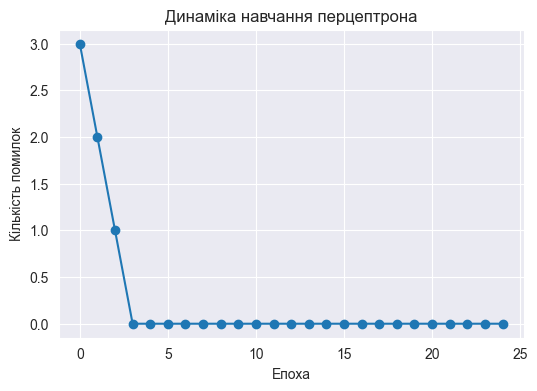

Зразок 1: [0.1 0.1 0.3] -> Яблуко 🍎
Зразок 2: [1.  0.8 0.5] -> Яблуко 🍎
Зразок 3: [0.3 0.6 0.7] -> Яблуко 🍎


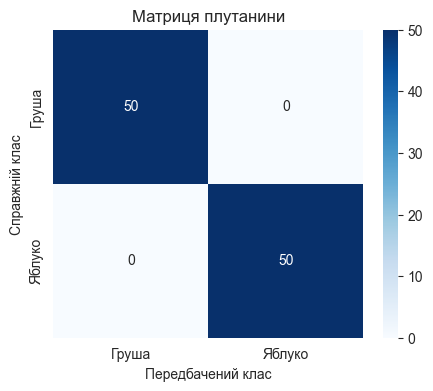

Звіт класифікації:
              precision    recall  f1-score   support

       Груша       1.00      1.00      1.00        50
      Яблуко       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ---------------------------
# 1. Генеруємо синтетичні дані
# ---------------------------
np.random.seed(42)

# Клас 0: груші (легкі, світлі)
pear_weight = np.random.normal(150, 30, 50)
pear_color = np.random.normal(0.3, 0.3, 50)
pear_roundness = np.random.normal(0.3, 0.1, 50)

# Клас 1: яблука (важчі, темніші)
apple_weight = np.random.normal(180, 30, 50)
apple_color = np.random.normal(0.7, 0.3, 50)
apple_roundness = np.random.normal(0.8, 0.1, 50)

# Об'єднуємо дані
X = np.vstack((
    np.column_stack((pear_weight, pear_color, pear_roundness)),
    np.column_stack((apple_weight, apple_color, apple_roundness))
))
y = np.array([0] * 50 + [1] * 50)

# Нормалізація ознак
X = (X - X.mean(axis=0)) / X.std(axis=0)


# ---------------------------
# 2. Візуалізація вихідних даних
# ---------------------------
def evaluate_model(model, X, y):
    y_pred = model.predict(X)

    # Матриця плутанини
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Груша', 'Яблуко'],
                yticklabels=['Груша', 'Яблуко'])
    plt.title("Матриця плутанини")
    plt.xlabel("Передбачений клас")
    plt.ylabel("Справжній клас")
    plt.show()

    # Звіт класифікації
    print("Звіт класифікації:")
    print(classification_report(y, y_pred, target_names=['Груша', 'Яблуко']))


# ---------------------------
# 3. Реалізація перцептрона з нуля
# ---------------------------
class Perceptron:
    def __init__(self, n_inputs, learning_rate=0.1, epochs=50):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = np.zeros(n_inputs)
        self.bias = 0.0

    def step(self, x):
        """Порогова функція активації"""
        return np.where(x >= 0, 1, 0)

    def predict(self, X):
        """Передбачення класу"""
        linear_output = np.dot(X, self.weights) + self.bias
        return self.step(linear_output)

    def fit(self, X, y):
        """Навчання моделі"""
        history = []
        for epoch in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                # evaluate_model(self, X, y)
                y_pred = self.predict(xi)
                update = self.lr * (target - y_pred)
                self.weights += update * xi
                self.bias += update
                errors += int(update != 0.0)
            history.append(errors)
            print(f"Епоха {epoch + 1}/{self.epochs} — помилки: {errors}")
        return history


# ---------------------------
# 4. Навчання моделі
# ---------------------------
model = Perceptron(n_inputs=3, learning_rate=0.1, epochs=25)
errors_history = model.fit(X, y)


# ---------------------------
# 5. Візуалізація процесу навчання
# ---------------------------
plt.figure(figsize=(6,4))
plt.plot(errors_history, marker='o')
plt.title("Динаміка навчання перцептрона")
plt.xlabel("Епоха")
plt.ylabel("Кількість помилок")
plt.grid(True)
plt.show()

# ---------------------------
# 6. Перевірка на нових даних
# ---------------------------
new_samples = np.array([
    [0.1, 0.1, 0.3],  # легка і світла -> груша
    [1.0, 0.8, 0.5],  # важка і темна -> яблуко
    [0.3, 0.6, 0.7],  # проміжне
])

predictions = model.predict(new_samples)
for i, p in enumerate(predictions):
    label = "Яблуко 🍎" if p == 1 else "Груша 🍐"
    print(f"Зразок {i + 1}: {new_samples[i]} -> {label}")

# Оцінка моделі на тестових даних
evaluate_model(model, X, y)